# Семинар 5. Оценки качества моделей в задачах регрессии и классификации

Подключение библиотек. 
$
\newcommand{\R}{\mathbb{R}}
\newcommand{\X}{\mathbb{X}}
\newcommand{\norm}[1]{\lVert #1 \rVert}
\newcommand{\abs}[1]{\left| #1 \right|}
\newcommand{\E}{\mathbb{E}}
\newcommand{\D}{\mathbb{D}}
\renewcommand{\Prob}{\mathbb{P}}
\renewcommand{\le}{\leqslant}
\renewcommand{\ge}{\geqslant}
\newcommand{\eps}{\varepsilon}
\newcommand{\Normal}{\mathcal{N}}
\DeclareMathOperator{\TP}{TP}
\DeclareMathOperator{\FP}{FP}
\DeclareMathOperator{\TN}{TN}
\DeclareMathOperator{\FN}{FN}
\DeclareMathOperator{\Accuracy}{Accuracy}
\DeclareMathOperator{\Precision}{Precision}
\DeclareMathOperator{\Recall}{Recall}
\DeclareMathOperator{\Fscore}{F_1}
\DeclareMathOperator{\MSE}{MSE}
\DeclareMathOperator{\RMSE}{RMSE}
\DeclareMathOperator{\MAE}{MAE}
\DeclareMathOperator{\MAPE}{MAPE}
\DeclareMathOperator{\Rsqured}{R^2}
$

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as wg

from matplotlib.colors import ListedColormap

import warnings
warnings.filterwarnings("ignore", 'This pattern has match groups')

RdGn = ListedColormap(['red', 'green'])
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 4)

# 1. Регрессия

Рассмотрим датасет __mpg__. По характеристикам машины необходимо спрогнозировать расход топлива.

Признаки:
* cylinders -- число цилиндров в двигателе;
* displacement -- рабочий объем, л;
* horsepower -- мощность, л.с.;
* weight -- вес, т;
* acceleration -- ускорение;
* model_year -- год выпуска модели;
* origin -- производитель;
* name -- название.

Целевая переменная:
* mpg -- миль на галлон, переведено в л/км.

In [2]:
frame = sns.load_dataset('mpg')
frame.dropna(inplace=True)

frame['displacement'] *= 16.3871 / 1000
frame['mpg'] = 100 / (frame.mpg * 1.60934 / 3.78541)
frame['weight'] *= 0.453592 / 1000

frame.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,name
0,13.067503,8,5.030840,130.0,1.589386,12.0,70,usa,chevrolet chevelle malibu
1,15.681004,8,5.735485,165.0,1.675115,11.5,70,usa,buick skylark 320
2,13.067503,8,5.211098,150.0,1.558542,11.0,70,usa,plymouth satellite
3,14.700941,8,4.981678,150.0,1.557181,12.0,70,usa,amc rebel sst
4,13.836180,8,4.948904,140.0,1.564439,10.5,70,usa,ford torino


Изучим данные:

In [5]:
frame.shape

(392, 9)

In [7]:
frame.cylinders.value_counts()

4    199
8    103
6     83
3      4
5      3
Name: cylinders, dtype: int64

In [6]:
frame.origin.value_counts()

usa       245
japan      79
europe     68
Name: origin, dtype: int64

In [8]:
frame.model_year.value_counts()

73    40
78    36
76    34
75    30
82    30
70    29
79    29
72    28
77    28
81    28
71    27
80    27
74    26
Name: model_year, dtype: int64

In [4]:
frame.describe()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year
count,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000
mean,11.248555,5.471939,3.185849,104.469388,1.350608,15.541327,75.979592
std,3.913846,1.705783,1.714812,38.491160,0.385282,2.758864,3.683737
min,5.047533,3.000000,1.114323,46.000000,0.731644,8.000000,70.000000
25%,8.110864,4.000000,1.720646,75.000000,1.009356,13.775000,73.000000
50%,10.340372,4.000000,2.474452,93.500000,1.271645,15.500000,76.000000
75%,13.836180,8.000000,4.518743,126.000000,1.639622,17.025000,79.000000
max,26.135006,8.000000,7.456131,230.000000,2.331463,24.800000,82.000000


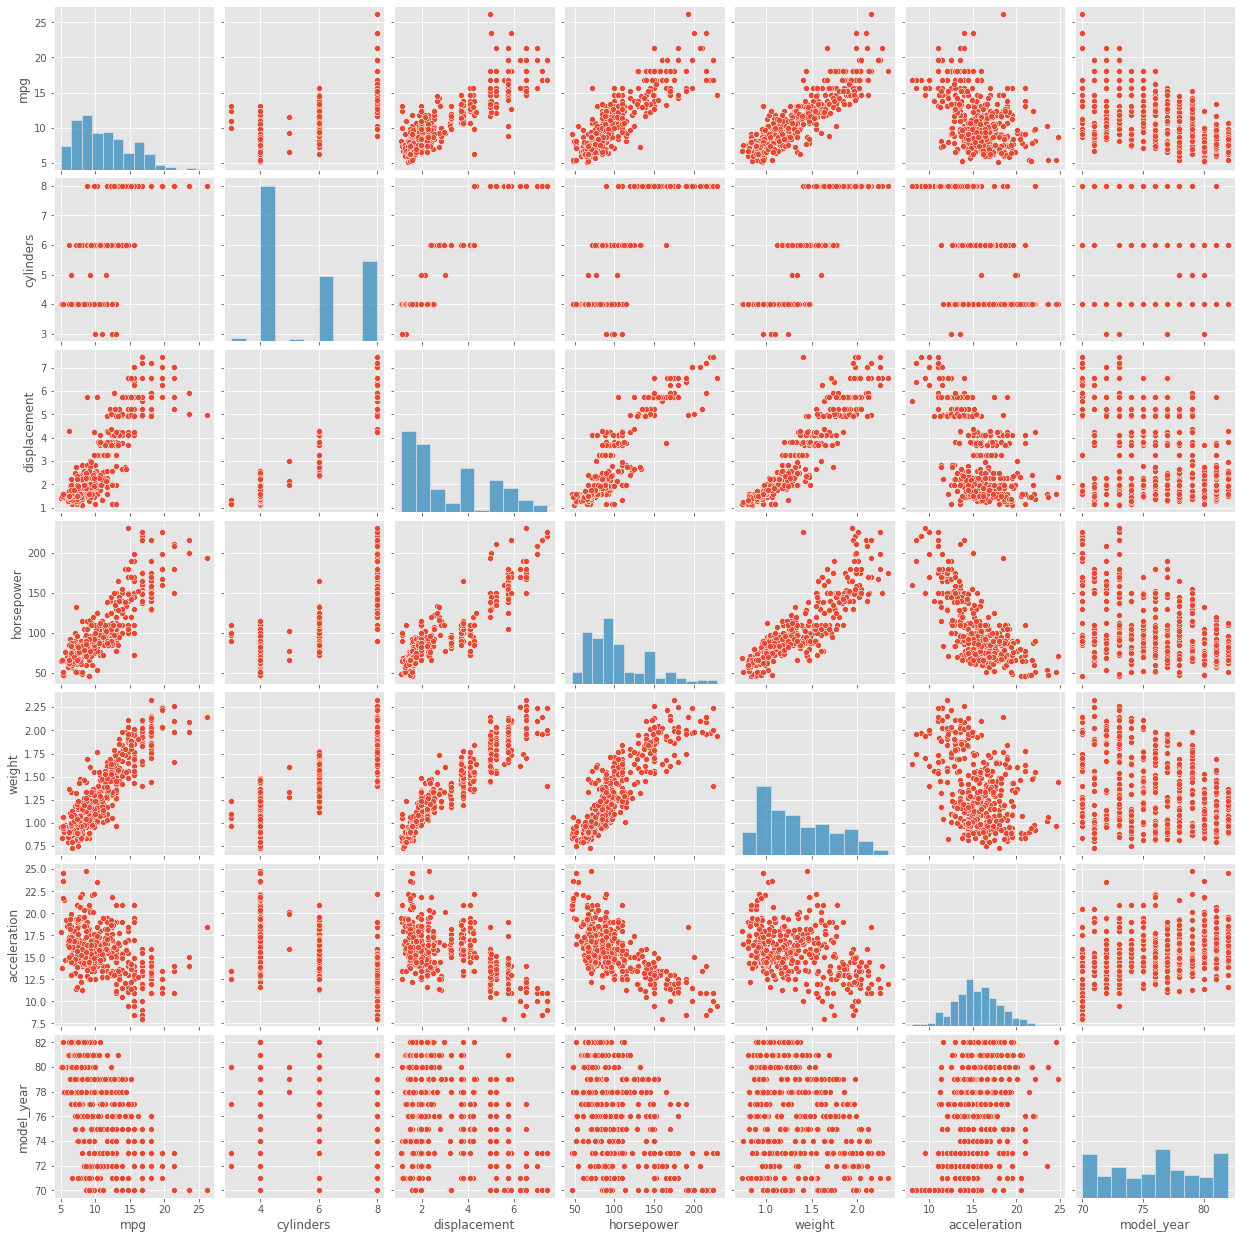

In [3]:
sns.pairplot(frame)

* Готовим данные.
* Разбиваем на train, validation и test.

In [9]:
X = frame.drop(columns=['mpg', 'name']).copy()
y = frame.mpg.copy()

In [10]:
from sklearn.model_selection import train_test_split


X_fit, X_test, y_fit, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_fit, y_fit, test_size=0.1, random_state=42)

print('Train size:', X_train.shape[0])
print('Valid size:', X_valid.shape[0])
print('Test size:', X_test.shape[0])

Train size: 281
Valid size: 32
Test size: 79


## Строим модель

Воспользуемся инструментами sklearn для организации препроцессинга данных и обучения модели:
* создадим transformer, который нормализует числовые и закодирует категориальные признаки;
* создадим estimator, который по признакам будет предсказывать расход топлива;
* объединим transformer и estimator в единый pipeline.

In [12]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder


transformer = make_column_transformer(
    (StandardScaler(), ['displacement', 'horsepower', 'weight', 'acceleration', 'cylinders', 'model_year']),
    (OneHotEncoder(sparse=False, drop='first'), ['origin'])
)
transformer

ColumnTransformer(transformers=[('standardscaler', StandardScaler(),
                                 ['displacement', 'horsepower', 'weight',
                                  'acceleration', 'cylinders', 'model_year']),
                                ('onehotencoder',
                                 OneHotEncoder(drop='first', sparse=False),
                                 ['origin'])])

In [13]:
from sklearn.linear_model import LinearRegression


estimator = LinearRegression()
estimator

LinearRegression()

In [14]:
from sklearn.pipeline import make_pipeline


model = make_pipeline(transformer, estimator)
model.fit(X_train, y_train)

pred_train = model.predict(X_train)
pred_valid = model.predict(X_valid)

Считаем метрики:
* Mean Absolute Error: $\frac{1}{\ell} \cdot \sum_{i=1}^{\ell} \abs{y_i - \hat{y}_i}.$
* Mean Squared Error: $\frac{1}{\ell} \cdot \sum_{i=1}^{\ell} (y_i - \hat{y}_i)^2.$
* Rooted Mean Squared Error: $\sqrt{\MSE(Y,\hat{Y})}.$
* Mean Absolute Percentage Error: $\frac{1}{\ell} \cdot \sum_{i=1}^{\ell} \abs{\frac{y_i - \hat{y}_i}{y_i}}.$
* R$^2$: $1 - \frac{\sum_{i=1}^{\ell}(y_i - \hat{y}_i)^2}{\sum_{i=1}^{\ell}(y_i - \overline{y})^2}.$

In [15]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


def regression_metrics(true, pred, plot=False):
    mae = mean_absolute_error(true, pred)
    mape = np.abs((true - pred) / true).mean()
    mse = mean_squared_error(true, pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(true, pred)

    print('MAE: ', mae)
    print('MSE: ', mse)
    print('RMSE:', rmse)
    print('MAPE:', mape)
    print('R2:  ', r2)
    print()
    
    if plot:
        plt.figure(0, (6, 6))
        plt.scatter(true, pred)
        low = min(true.min(), pred.min())
        high = max(true.max(), pred.max())

        plt.plot([low, high], [low, high], color='blue')
        plt.xlabel('Ground Truth')
        plt.ylabel('Prediction')
        plt.show()

Train:
MAE:  1.0065767747191545
MSE:  1.8271676975020517
RMSE: 1.3517276713532396
MAPE: 0.09233873912841212
R2:   0.8882760011903309

Valid:
MAE:  0.933376581613611
MSE:  1.5088912483804964
RMSE: 1.2283693452624485
MAPE: 0.09445993335261486
R2:   0.8083777215198819



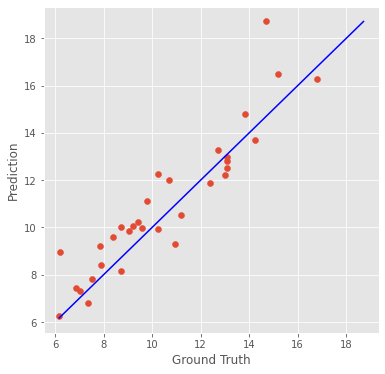

In [16]:
print('Train:')
regression_metrics(y_train, pred_train)

print('Valid:')
regression_metrics(y_valid, pred_valid, plot=True)

__Задача (5 минут):__ 
* обучить модель с регуляризацией;
* посчитать метрики на тренировочной выборке и валидационной выборке.

Train:
MAE:  0.9911118735503978
MSE:  1.8681294837969211
RMSE: 1.3667953335437317
MAPE: 0.09024111962931386
R2:   0.8857713517432625

Valid:
MAE:  0.9028643761753872
MSE:  1.5583656469796474
RMSE: 1.2483451633981875
MAPE: 0.09286080058222627
R2:   0.8020946994689698



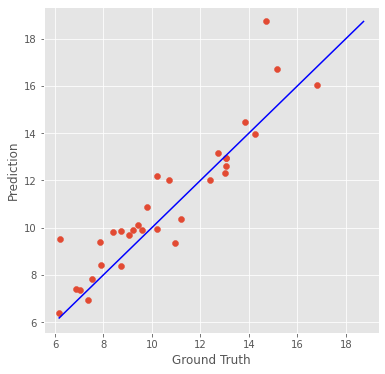

In [19]:
from sklearn.linear_model import Ridge

r_estimator = Ridge(alpha=10.0)
r_model = make_pipeline(transformer, r_estimator)
r_model.fit(X_train, y_train)

r_pred_train = r_model.predict(X_train)
r_pred_valid = r_model.predict(X_valid)

print('Train:')
regression_metrics(y_train, r_pred_train)

print('Valid:')
regression_metrics(y_valid, r_pred_valid, plot=True)

__Задача (5 минут):__ 
* выбрать метрику для отбора параметра регуляризации;
* построить график зависимости метрики от параметра;
* найти лучшие параметры регуляризации по выбранной метрике.

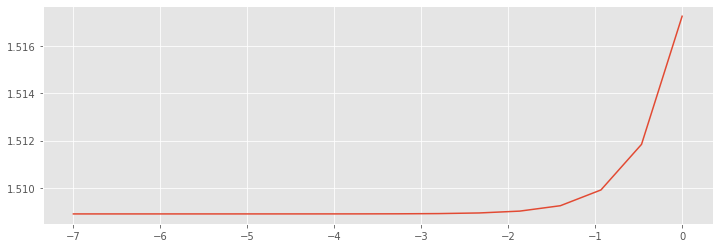

In [26]:
valid_mse = []

# for A in range(0, 10):
A_list = np.logspace(-7, 0, 16)
for A in A_list:
    estimator_ridge = Ridge(alpha=A)
    model_ridge = make_pipeline(transformer, estimator_ridge)
    model_ridge.fit(X_train, y_train)
    
    ridge_pred_valid = model_ridge.predict(X_valid)
    valid_mse.append(mean_squared_error(y_valid, ridge_pred_valid))
    
plt.plot(np.log10(A_list), valid_mse)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
Train:
MAE:  0.9877762236522336
MSE:  1.863360113142622
RMSE: 1.36504949109643
MAPE: 0.0899344892557204
R2:   0.8860629796885421

Valid:
MAE:  0.9043148273522938
MSE:  1.5313918985044834
RMSE: 1.2374942014023675
MAPE: 0.09310173136336074
R2:   0.8055202419973052



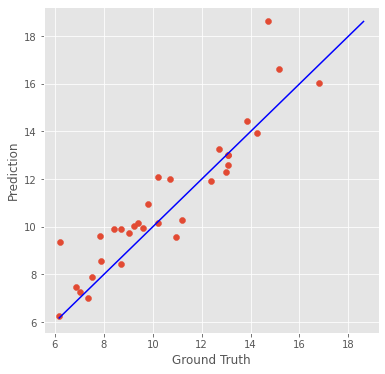

In [34]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

est = Lasso()
grid_params = {'est__alpha': np.logspace(-5, -1, 32)}

model = Pipeline([('transformer', transformer), 
                                 ('est', est)])


locally_best_model = GridSearchCV(model, 
                                 grid_params, 
                                 scoring='neg_mean_squared_error',  
                                 n_jobs=-1, cv=5,
                                 verbose=True)


locally_best_model.fit(X_train, y_train)

pred_train = locally_best_model.predict(X_train)
pred_valid = locally_best_model.predict(X_valid)

print('Train:')
regression_metrics(y_train, pred_train)

print('Valid:')
regression_metrics(y_valid, pred_valid, plot=True)

In [37]:
10 ** (-3 / 2)

0.03162277660168379

Text(0, 0.5, 'cv scores for alpha')

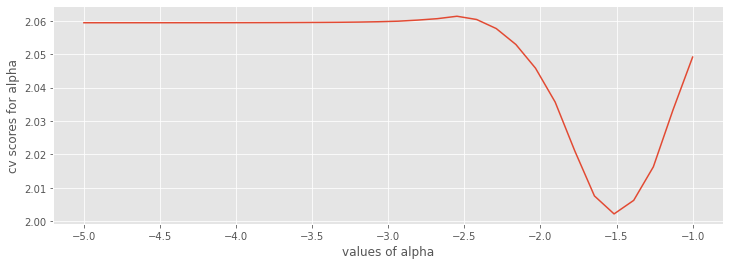

In [36]:
plt.plot(np.log10(grid_params['est__alpha']), -locally_best_model.cv_results_['mean_test_score'])
plt.xlabel('values of alpha')
plt.ylabel('cv scores for alpha')

__Задача (5 минут):__ 
* обучить итоговую модель с лучшими параметрами на полной тренировочной выборке (train + valid);
* оценить итоговую модель на выборке Test.

Test:
MAE:  0.9472197830304858
MSE:  1.5369874042929488
RMSE: 1.2397529609938218
MAPE: 0.0839166826015692
R2:   0.8916070268670595



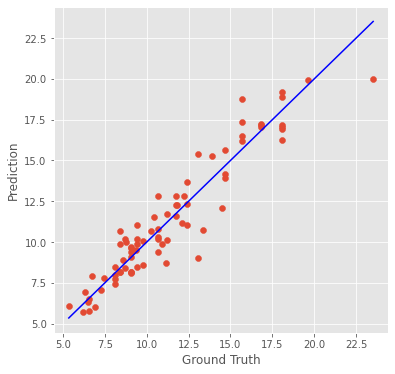

In [39]:
m_final = locally_best_model.best_estimator_
m_final.fit(X_fit, y_fit)
pred_final = m_final.predict(X_test)

print('Test:')
regression_metrics(y_test, pred_final, plot=True)

Test:
MAE:  0.9814226179291559
MSE:  1.5618062795314658
RMSE: 1.2497224810058696
MAPE: 0.08877176233269408
R2:   0.8898567251603543



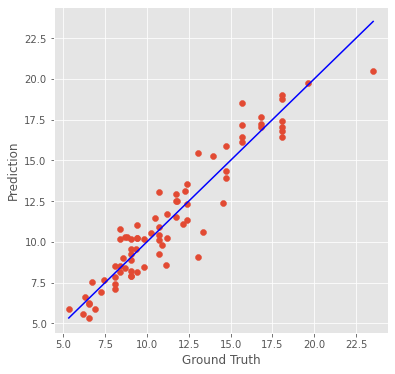

In [38]:
est_final = Ridge(alpha=0)

m_final = make_pipeline(transformer, est_final)
m_final.fit(X_fit, y_fit)
pred_final = m_final.predict(X_test)

print('Test:')
regression_metrics(y_test, pred_final, plot=True)

# 2. Классификация

__Титаник:__
* survived -- спасен или нет;
* pclass -- социально-экономический статус (1 -- upper, 2 -- middle, 3 -- lower);
* sex -- пол;
* age -- возраст;
* sibsp -- число ближайших родственников на борту (муж/жена, брат/сестра);
* parch -- число родителей/детей на борту;
* fare -- плата за проезд;
* embarked -- место посадки.

In [40]:
frame = sns.load_dataset('titanic')
frame = frame[['pclass', 'sex', 'age', 'fare', 'survived']].dropna()

print('Shape:', frame.shape)
frame.head()

Shape: (714, 5)


,pclass,sex,age,fare,survived
0,3,male,22.0,7.2500,0
1,1,female,38.0,71.2833,1
2,3,female,26.0,7.9250,1
3,1,female,35.0,53.1000,1
4,3,male,35.0,8.0500,0


Готовим данные:

In [41]:
X = frame[['pclass', 'sex', 'age', 'fare']].copy()
y = frame['survived'].copy()

Разбиваем данные на train, valid, test:

In [42]:
from sklearn.model_selection import train_test_split


X_fit, X_test, y_fit, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_fit, y_fit, test_size=0.1, random_state=42)

print('Train size:', X_train.shape[0])
print('Valid size:', X_valid.shape[0])
print('Test size:', X_test.shape[0])

Train size: 513
Valid size: 58
Test size: 143


## Строим модель

Как и в задаче регрессии:
* создадим transformer, который нормализует числовые и закодирует категориальные признаки;
* создадим estimator, который по признакам будет предсказывать целевую переменную (выживет ли человек);
* объединим transformer и estimator в единый pipeline.

In [43]:
transformer = make_column_transformer(
    (StandardScaler(), ['age', 'fare']),
    (OneHotEncoder(sparse=False, drop='first'), ['pclass', 'sex'])
)
transformer

ColumnTransformer(transformers=[('standardscaler', StandardScaler(),
                                 ['age', 'fare']),
                                ('onehotencoder',
                                 OneHotEncoder(drop='first', sparse=False),
                                 ['pclass', 'sex'])])

In [44]:
from sklearn.linear_model import LogisticRegression


estimator = LogisticRegression(penalty='none')
estimator

LogisticRegression(penalty='none')

Учим модель:

In [45]:
model = make_pipeline(transformer, estimator)
model.fit(X_train, y_train)

pred_train = model.predict(X_train)
pred_valid = model.predict(X_valid)

prob_valid = model.predict_proba(X_valid)

Считаем метрики:

In [48]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve
)


def classification_metrics(true, pred, prob=None, plot=False):
    acc = accuracy_score(true, pred)
    prec = precision_score(true, pred)
    rec = recall_score(true, pred)
    f1 = f1_score(true, pred)
    roc_auc = roc_auc_score(true, pred)
    
    print('Accuracy:', acc)
    print('Precision:', prec)
    print('Recall:', rec)
    print('F1-score:', f1)
    print('AUC ROC:', roc_auc)
    print()
    
    if plot:
        assert prob is not None, 'prob should be non-None'
        plt.figure(0, (6, 6))
        fpr, tpr, _ = roc_curve(true, prob[:, 1])
        plt.plot(fpr, tpr)
        plt.plot([0, 1], [0, 1], ls='--', label='random choice')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC-curve')
        plt.legend()
        plt.show()

Train:
Accuracy: 0.8070175438596491
Precision: 0.7766497461928934
Recall: 0.7355769230769231
F1-score: 0.7555555555555556
AUC ROC: 0.795657313997478

Valid:
Accuracy: 0.7758620689655172
Precision: 0.782608695652174
Recall: 0.6923076923076923
F1-score: 0.7346938775510203
AUC ROC: 0.7680288461538461



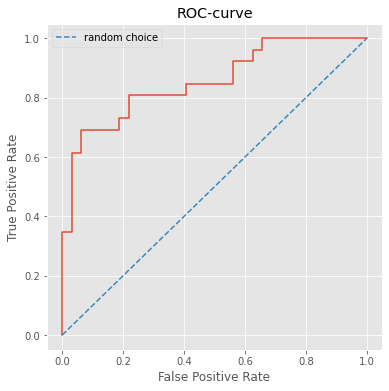

In [49]:
print('Train:')
classification_metrics(y_train, pred_train)

print('Valid:')
classification_metrics(y_valid, pred_valid, prob_valid, plot=True)

__Задача (5 минут):__ 
* обучить модель с регуляризацией;
* посчитать метрики на тренировочной выборке и валидационной выборке.

Train:
Accuracy: 0.8109161793372319
Precision: 0.7846153846153846
Recall: 0.7355769230769231
F1-score: 0.7593052109181141
AUC ROC: 0.7989360025220681

Valid:
Accuracy: 0.7758620689655172
Precision: 0.782608695652174
Recall: 0.6923076923076923
F1-score: 0.7346938775510203
AUC ROC: 0.7680288461538461



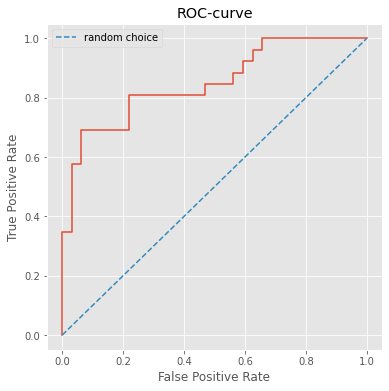

In [53]:
estimator_l1 = LogisticRegression(penalty='l1', solver='saga', max_iter=8192)
model_l1 = make_pipeline(transformer, estimator_l1)
model_l1.fit(X_train, y_train)

pred_train_l1 = model_l1.predict(X_train)
pred_valid_l1 = model_l1.predict(X_valid)

prob_valid_l1 = model_l1.predict_proba(X_valid)

print('Train:')
classification_metrics(y_train, pred_train_l1)

print('Valid:')
classification_metrics(y_valid, pred_valid_l1, prob_valid_l1, plot=True)

__Задача (5 минут):__ 
* выбрать метрику для отбора параметра регуляризации;
* построить график зависимости метрики от параметра;
* найти лучшие параметры регуляризации по выбранной метрике.

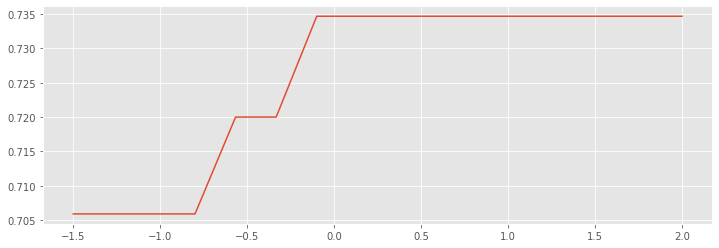

In [69]:
C_list = np.logspace(-3/2, 2, 16)
f = []

for C in C_list:
    estimator_c = LogisticRegression(penalty='l1', C=C, solver = 'saga', max_iter=8192)
    model_c = make_pipeline(transformer, estimator_c)
    model_c.fit(X_train, y_train)

    pred_train_c = model_c.predict(X_train)
    pred_valid_c = model_c.predict(X_valid)

    prob_valid_c = model_c.predict_proba(X_valid)
    f.append(f1_score(y_valid, pred_valid_c))
plt.plot(np.log10(C_list), f)

__Задача (5 минут):__ 
* обучить итоговую модель с лучшими параметрами на полной тренировочной выборке (train + valid);
* оценить итоговую модель на выборке Test.

In [73]:
print(y_train.mean())
print(y_valid.mean())
print(y_test.mean())

0.40545808966861596
0.4482758620689655
0.3916083916083916


Test:
Accuracy: 0.7482517482517482
Precision: 0.6724137931034483
Recall: 0.6964285714285714
F1-score: 0.6842105263157895
AUC ROC: 0.739018883415435



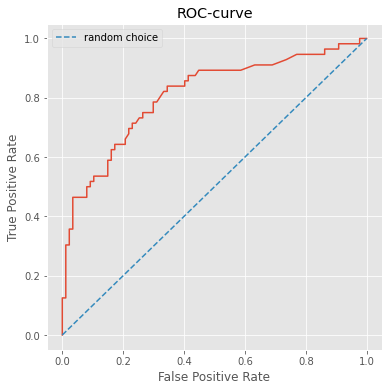

In [70]:
C = 1
estimator_final = LogisticRegression(penalty='l1', C=C, solver='saga', max_iter=8192)
model_final = make_pipeline(transformer, estimator_final)
model_final.fit(X_fit, y_fit)

pred_test_final = model_final.predict(X_test)

prob_test_final = model_final.predict_proba(X_test)

print('Test:')
classification_metrics(y_test, pred_test_final, prob_test_final, plot=True)

# 3. Упражнения
* реализовать функции вычисления метрик регрессии;
* реализовать функции вычисления метрик классификации;
* реализовать функцию вычисления ROC-кривой.

### 3.1. Регрессия

In [ ]:
N = 128

true = np.random.normal(0, 1, size=N)
pred = np.random.normal(0, 1, size=N)

In [ ]:
def mae(true, pred):
    return np.zeros_like(true).mean()

assert np.isclose(mae(true, pred), mean_absolute_error(true, pred)), 'Wrong answer'

In [ ]:
def mse(true, pred):
    return np.zeros_like(true).mean()

assert np.isclose(mse(true, pred), mean_squared_error(true, pred)), 'Wrong answer'

In [ ]:
def r2(true, pred):
    return np.zeros_like(true).mean()

assert np.isclose(r2(true, pred), r2_score(true, pred)), 'Wrong answer'

## 3.2. Классификация

In [ ]:
N = 128

true = np.random.choice(2, size=N)
prob = np.random.uniform(size=N)
pred = (prob > 0.9).astype(float)

In [ ]:
def accuracy(true, pred):
    return np.zeros_like(true).mean()

assert np.isclose(accuracy(true, pred), accuracy_score(true, pred)), 'Wrong answer'

In [ ]:
def recall(true, pred):
    return np.zeros_like(true).mean()

assert np.isclose(recall(true, pred), recall_score(true, pred)), 'Wrong answer'

In [ ]:
def precision(true, pred):
    return np.zeros_like(true).mean()

assert np.isclose(precision(true, pred), precision_score(true, pred)), 'Wrong answer'

## 3.3. ROC-кривая

In [ ]:
def roc(true, prob):
    return np.linspace(0, 1, true.shape[0]), np.linspace(0, 1, true.shape[0])

fpr, tpr = roc(true, prob)
fpr_gt, tpr_gt, _ = roc_curve(true, prob)

plt.figure(0, (6, 6))
plt.plot(fpr, tpr, label='Ours', color='blue')
plt.plot(fpr_gt, tpr_gt, label='GT', color='green')
plt.plot([0, 1], [0, 1], ls='--', color='purple', label='random choice')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-curve')
plt.legend()
plt.show()

In [74]:
N = 256
d = 4

X = np.random.normal(size=(N, d))
X.shape

(256, 4)

In [84]:
# dist = [i, j, k]
# dist[i, j].shape = 4
X.reshape((1, N, d)).shape
X.reshape((N, 1, d)).shape

Z = X.reshape((1, N, d)) * X.reshape((N, 1, d))
Z = Z.sum(axis=2)
Z

array([[ 2.55966257, -1.88281961,  0.83445619, ..., -1.53260945,
         1.28860911,  1.54595965],
       [-1.88281961,  4.93888509,  0.18261219, ..., -0.24777761,
        -2.77100294,  0.36584907],
       [ 0.83445619,  0.18261219,  3.24008283, ..., -1.47392258,
         0.51213378,  1.992533  ],
       ...,
       [-1.53260945, -0.24777761, -1.47392258, ...,  3.17674296,
         0.00532689, -1.7251139 ],
       [ 1.28860911, -2.77100294,  0.51213378, ...,  0.00532689,
         1.69707733,  0.22088758],
       [ 1.54595965,  0.36584907,  1.992533  , ..., -1.7251139 ,
         0.22088758,  2.04695745]])

In [91]:
X[np.newaxis].shape

(1, 256, 4)

In [101]:
X[None].shape

(1, 256, 4)

In [102]:
X[:, None].shape

(256, 1, 4)

In [104]:
X1 = X.reshape((1, N, d))
X1 = np.repeat(X1, N, axis=0)
X1.shape

(256, 256, 4)

In [105]:
X2 = X.reshape((N, 1, d))
X2 = np.repeat(X2, N, axis=1)
X2.shape

(256, 256, 4)

In [108]:
np.abs((X1 * X2).sum(axis=2) - Z).max()

0.0

In [ ]:
# newaxis = None

In [113]:
type(np.newaxis)

NoneType

In [114]:
type(None)

NoneType

In [112]:
# D[i, j, k] = a[i] + b[j] + c[k]
N, M, K = 10, 15, 7
a = np.random.normal(size=N)
b = np.random.normal(size=M)
c = np.random.normal(size=K)
D = a[:, None, None] + b[None, :, None] + c[None, None, :]
D = a[:, None, None] + b[None, :, None] + c[None, None]
D.shape

(10, 15, 7)

In [100]:
Z = X[:, None] * X[None]
Z = Z.sum(axis=2)
Z

array([[ 2.55966257, -1.88281961,  0.83445619, ..., -1.53260945,
         1.28860911,  1.54595965],
       [-1.88281961,  4.93888509,  0.18261219, ..., -0.24777761,
        -2.77100294,  0.36584907],
       [ 0.83445619,  0.18261219,  3.24008283, ..., -1.47392258,
         0.51213378,  1.992533  ],
       ...,
       [-1.53260945, -0.24777761, -1.47392258, ...,  3.17674296,
         0.00532689, -1.7251139 ],
       [ 1.28860911, -2.77100294,  0.51213378, ...,  0.00532689,
         1.69707733,  0.22088758],
       [ 1.54595965,  0.36584907,  1.992533  , ..., -1.7251139 ,
         0.22088758,  2.04695745]])

In [88]:
Z_gt = np.zeros((N, N))
for i in range(N):
    for j in range(N):
        Z_gt[i, j] = (X[i] * X[j]).sum()

In [90]:
np.abs(Z_gt - Z).max()

0.0